### Задача

Используя доступный набор данных о посещении страниц у одной части пользователей, сделать прогноз относительно **пола и возрастной категории** другой части пользователей. Угадывание (hit) - правильное предсказание и пола, и возрастной категории одновременно.

Мы не ограничиваем вас в выборе инструментов и методов работы с данными. Используйте любые эвристики, внешние источники, парсинг контента страниц — всё, что поможет вам выполнить задачу. Единственное ограничение — никаких ручных действий. Руками проставлять классы нельзя.

Поскольку это ваш проект, который мы наверняка захотите показать другим, уделите его оформлению достаточно времени. Мы рекомендуем сделать весь проект в этом ноутбуке. Снизу, под заданием, вы сможете описать ваше решение.

⏰ **Дедлайн: 06 мая 2018, 23:59**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import os, sys
import json
from urllib.parse import urlparse
from urllib.request import urlretrieve, unquote

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from xgboost import XGBClassifier
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from collections import Counter
import seaborn as sns
from sklearn.metrics import accuracy_score
plt.style.use('ggplot')

# Обработка данных на вход

In [3]:
# First, we download the input data for the project:

# data_dir = 'data'
data_dir = '/home/artem/NewProLab/project01/'
filename = 'gender_age_dataset.txt'
file_path = '/'.join([data_dir,filename])
url = 'http://data.newprolab.com/data-newprolab-com/project01/' + filename

if not os.path.isdir(data_dir): os.mkdir(data_dir)
if not os.path.isfile(file_path):
    print('Downloading ' + filename + '...')
    urlretrieve(url, file_path)
    print('Download completed')

# Wait until you see that all files have been downloaded.
print('OK')

OK


In [4]:
df = pd.read_csv(file_path, sep='\t')

In [5]:
df.head()

,gender,age,uid,user_json
0,F,18-24,d50192e5-c44e-4ae8-ae7a-7cfe67c8b777,"{""visits"": [{""url"": ""http://zebra-zoya.ru/2000..."
1,M,25-34,d502331d-621e-4721-ada2-5d30b2c3801f,"{""visits"": [{""url"": ""http://sweetrading.ru/?p=..."
2,F,25-34,d50237ea-747e-48a2-ba46-d08e71dddfdb,"{""visits"": [{""url"": ""http://ru.oriflame.com/pr..."
3,F,25-34,d502f29f-d57a-46bf-8703-1cb5f8dcdf03,"{""visits"": [{""url"": ""http://translate-tattoo.r..."
4,M,>=55,d503c3b2-a0c2-4f47-bb27-065058c73008,"{""visits"": [{""url"": ""https://mail.rambler.ru/#..."


В файле есть 4 поля:
* **gender** - пол, принимающий значения `M` (male - мужчина), `F` (female - женщина), `-` (пол неизвестен);
* **age** - возраст, представленный в виде диапазона x-y (строковый тип), или `-` (возрастная категория неизвестна);
* **uid** - идентификатор пользователя, строковая переменная;
* **user_json** - поле json, в котором содержатся записи о посещении сайтов этим пользователем `(url, timestamp)`.

In [6]:
%%time
# распарсим json-ы для всего датафрейма
df['user_json_parsed'] = df['user_json'].apply(json.loads)

CPU times: user 6.53 s, sys: 1.39 s, total: 7.92 s
Wall time: 29.6 s


# Очистка данных и feature engineering

Вытащим домены и будем использовать их в качестве признаков.

In [7]:
def url2domain(url):
    url = re.sub('(http(s)*://)+', 'http://', url)
    parsed_url = urlparse(unquote(url.strip()))
    if parsed_url.scheme not in ['http','https']: 
        return None
    netloc = re.search("(?:www\.)?(.*)", parsed_url.netloc).group(1)
    if netloc is not None: 
        return netloc
    return None

In [8]:
def get_domains(df):
    domains_list = []
    for i in range(len(df)):
        visits = df.iloc[i]['user_json_parsed']['visits']
        domains_per_uid = []
        for site in visits:
            domains_per_uid.append(url2domain(site['url']))
        domains_list.append(domains_per_uid)
    df = df.copy()
    df['domains'] = domains_list
    return df

In [9]:
%%time
df_domains = get_domains(df)
df_domains_m = df_domains[df_domains['gender'] == 'M']
df_domains_f = df_domains[df_domains['gender'] == 'F']

CPU times: user 1min 41s, sys: 1.74 s, total: 1min 42s
Wall time: 1min 50s


In [10]:
def site_counter(df_domains, top_num):
    lst = []
    for i in range(len(df_domains)):
        lst.append(df_domains.iloc[i]['domains'])
    flat_list = [item for sublist in lst for item in sublist]
    
    c = Counter()
    for word in flat_list:
        c[word] += 1
    
    return c.most_common(top_num)

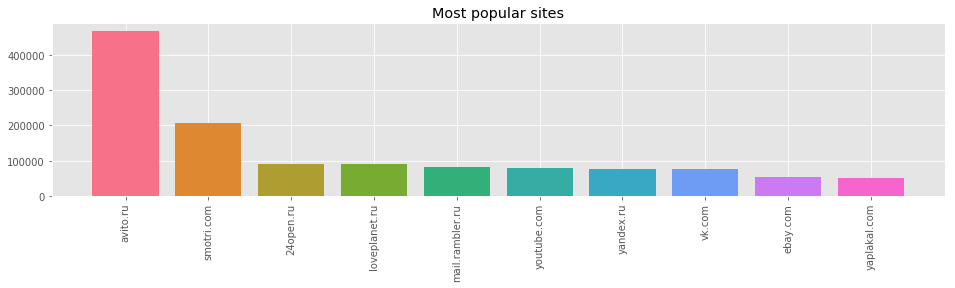

In [11]:
popularity_sites = site_counter(df_domains, 10);
# popularity_sites_f = site_counter(df_domains_f, 10);
# popularity_sites_m = site_counter(df_domains_m, 10);

x = range(len(popularity_sites))
y_value = [val[1] for val in popularity_sites]
y_label = [val[0] for val in popularity_sites]

plt.figure(figsize=(16, 5));
plt.title('Most popular sites');
plt.bar(x, y_value, color=sns.color_palette("husl", 10));
plt.xticks(x, y_label);
plt.xticks(rotation=90);
plt.gcf().subplots_adjust(bottom=0.4)

### Bag of sites

In [12]:
def make_bag_of_sites_df(feat_num):
    top_n = [val[0] for val in site_counter(df_domains, feat_num)]    
    vec_top_n = []
    for i in range(len(df_domains)):
        uid_domains = df_domains.iloc[i]['domains']
        uid_vec_top_n = []
        for d in top_n:
            uid_vec_top_n.append(uid_domains.count(d))
        vec_top_n.append(uid_vec_top_n)
    return pd.DataFrame(vec_top_n, columns=top_n)

bag_of_sites = make_bag_of_sites_df(feat_num=300)

In [13]:
df_res = pd.concat([df_domains, bag_of_sites], axis=1)
df_res = df_res.drop(['uid', 'user_json', 'user_json_parsed', 'domains'], axis=1)

In [14]:
df_res.tail()

,gender,age,avito.ru,smotri.com,24open.ru,loveplanet.ru,mail.rambler.ru,youtube.com,yandex.ru,vk.com,...,ru.jobrapido.com,date.bluesystem.ru,speedtest.net,retest.me,tempfile.ru,vtraxe.com,ridus.ru,live.russia.tv,i6.webware.ru,love.nnovgorod.net
41133,-,-,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
41134,-,-,0,0,0,0,0,0,5,0,...,0,0,0,0,0,0,0,0,0,0
41135,-,-,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
41136,-,-,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41137,-,-,0,0,0,0,0,0,3,0,...,0,0,0,0,0,0,0,0,0,0


### Деление на train и test сеты, обучение модели, предсказания для test-сета

In [15]:
train_df = df_res[~((df_res.gender == '-') & (df_res.age == '-'))]
test_df = df_res[(df_res.gender == '-') & (df_res.age == '-')]
print('train/test split:', len(train_df), len(test_df))

train/test split: 36138 5000


#### Посмотрим на сбалансированность выборки по целевым переменным

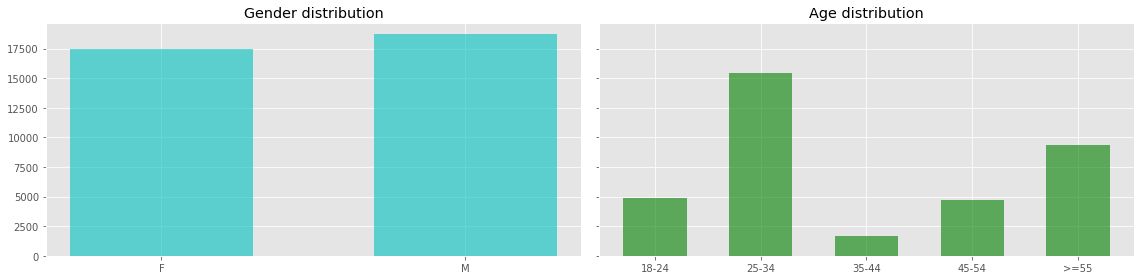

In [273]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True, figsize=(16,4))

ax1.set_title('Gender distribution')
ax1.bar(x=['F', 'M'], 
        height=(len(train_df[train_df['gender'] == 'F']), len(train_df[train_df['gender'] == 'M'])),
        width=0.6, color='c', alpha=0.6);

ax2.set_title('Age distribution')
ax2.bar(x=train_df['age'].unique(), 
        height=train_df.groupby('age').count().reset_index()['gender'].values,
        width=0.6, color='g', alpha=0.6);

plt.tight_layout()

In [16]:
train_df = train_df.drop('age', axis=1)
test_df = test_df.drop(['gender', 'age'], axis=1)

In [17]:
# f - 0, m -1
train_df['gender'] = pd.Series(train_df['gender']).astype('category').cat.codes

In [18]:
train_df.head()

,gender,avito.ru,smotri.com,24open.ru,loveplanet.ru,mail.rambler.ru,youtube.com,yandex.ru,vk.com,ebay.com,...,ru.jobrapido.com,date.bluesystem.ru,speedtest.net,retest.me,tempfile.ru,vtraxe.com,ridus.ru,live.russia.tv,i6.webware.ru,love.nnovgorod.net
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,46,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
X = train_df.drop(['gender'], axis=1)
y = train_df['gender']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [20]:
clf = RandomForestClassifier(n_jobs=3, n_estimators=500, max_depth=None, min_samples_split=2, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.63078767755026743

In [21]:
# sorted(list(zip(clf.feature_importances_, X_train.columns)), reverse=True)[:15]

In [25]:
model = XGBClassifier(max_depth=10, learning_rate=0.05, n_estimators=500)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [26]:
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

0.6470208448625715

### Сохранение модели

Обучать модель вы можете в ноутбуке - это удобно. А после того как модель обучилась и стала выдавать приемлемое качество на вашей валидационной выборке, сохраните ее в отдельном файле (например, используя pickle):

In [ ]:
#Сохранить модель, которая содержится в переменной vectorizer
import pickle
with open('TfidfVectorizer.pickle', 'wb') as f:
    pickle.dump(vectorizer, f)


Однако, не забудьте сохранить и код генерации признаков и обучения модели - это нужно для воспроизводимости результатов.

### Обработка тестовых данных и формат вывода результатов

Помимо того, что у вас должна получиться точная модель, вам нужно уложиться в SLA (service-level agreement). Всё почти как по-настоящему. Результатом вашей работы в данном случае будет не выходной файл, в котором вы всё посчитали для скрытой выборки, а скрипт, который мы будем запускать и проверять SLA и точность.

Вот фрагмент кода, который считывает данные построчно из потока стандартного ввода:

In [19]:
data = pd.DataFrame(columns=['gender','age','uid','user_json'])
s=0
for line in sys.stdin:
    data.loc[s] = line.strip().split("\t")
    s+=1

Задача вашего скрипта сделать предсказание по всем полученным строкам и выдать результат в формате json. В файле должны быть только те пользователи, у которых пол и возрастная категория изначально неизвестны, и они должны быть **отсортированы по UID по возрастанию значений лексикографически.** Пример вывода указан ниже.

In [ ]:
output = output[['uid', 'gender', 'age']]
output.sort_values(by='uid',axis = 0, ascending = True, inplace = True)
sys.stdout.write(output.to_json(orient='records'))

**Примечание**. Так как в данном проекте вам потребуется сохранять обученные модели в файле, то в вашем коде их нужно загружать явным образом. Иначе чекер не сможет запусть ваш скрипт корректно. Пример:

In [ ]:
#считать модель из файла в переменную vectorizer
import pickle
vectorizer= pickle.load(open('/data/home/test.user.bd8/TfidfVectorizer.pickle', 'rb'))

Для самопроверки вы можете локально оттестировать свой скрипт, используя следующую команду:

In [ ]:
!tail -n1000 gender_age_dataset.txt | python3 project01_gender-age.py > output.json

### Подсказки

1. Есть много различных способов решить данную задачу: можно просто хорошо поработать с урлами и доменами, можно пропарсить содержимое этих урлов (заголовки, текст и т.д.) и воспользоваться неким векторизатором типа TF\*IDF для генерации дополнительных фич, которые уже в дальнейшем вы подадите на вход ML-алгоритму, можно сделать тематическое моделирование (LDA, BigARTM) сайтов и использовать одну или несколько тем в качестве фич.

2. Возможно, что данные грязные и их нужно дополнительно обработать. Спецсимволы, кириллические домены? Уделите этому этапу достаточно времени: здесь чистота датасета важнее, чем выбор алгоритма.

3. Часто бывает, что лучшее решение с точки зрения результата — оно же самое простое. Попробуйте сначала простые способы, простые алгоритмы, прежде чем переходить к тяжёлой артиллерии. Один из вариантов — начать с небольшого RandomForest.

4. Вам почти наверняка понадобится что-то из пакета sklearn. [Документация](http://scikit-learn.org/stable/user_guide.html) — ваш лучший друг.

5. Вы можете сначала предсказать пол, а затем возраст, либо сразу и то, и другое. Экспериментируйте.

6. Объединяйтесь в команды. Так гораздо веселее и интереснее.

### Проверка
Проверка осуществляется из [Личного кабинета](http://lk.newprolab.com/lab/project1). До дедлайна вы будете проверять работу своего скрипта на валидационной выборке (2 000 записей). При наступлении дедлайна мы автоматически пересчитаем модели по скрытой тестовой выборке (3 000 записей). Это и будет финальным результатом.

* В поле `part of users with predicted gender + age` - указана доля пользователей, которая была предсказана от общего числа неизвестных пользователей (пример: по 3 000 был сделан прогноз, а всего было неизвестно 5 000, чекер выдаст 0.6).

* В поле `correctly predicted users / total number of users` - указана доля пользователей, которая была правильно предсказана (совпадает и пол, и возраст) от общего числа всех пользователей (пример: по 3 000 был сделан прогноз, правильно было спрогнозировано 1 500, а всего было неизвестно 5 000, чекер выдаст 0.3)

* В поле `correctly predicted users / number of predicted users` - указана доля пользователей, которая была правильно предсказана (совпадает и пол, и возраст) от общего числа предсказанных пользователей (пример: по 3 000 был сделан прогноз, из них правильно предсказано 1 500, чекер выдаст 0.5).

**Важное замечание!** Вы должны дать прогноз хотя бы по 50% пользователей, у которых изначально не указан пол и возрастная категория. Иными словами, вы можете оставить неопределенными не более 50% изначально неопределенных пользователей.

**Если доля в последнем поле превысит порог 0.28, то проект будет засчитан, при условии что выполнен SLA в 0.04 секунды**

Лучшей команде, набравшей максимальный результат, мы подарим специальный приз, о котором скажем позднее.